In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math
import netCDF4 as nc4


In [2]:
# define the input directory
input_dir = '/Users/account/Desktop/CS 185C/cs185c_fall2024/PROJECT/input'
print(input_dir)

/Users/account/Desktop/CS 185C/cs185c_fall2024/PROJECT/input


In [7]:
data_folder = '/Volumes/SanDisk/PROJECT DATA'
print(data_folder)

/Volumes/SanDisk/PROJECT DATA


In [8]:
from eccoseas.ecco import grid

In [9]:
ecco_XC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='XC')
ecco_YC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='YC')
ecco_hFacC_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacC')
ecco_hFacW_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacW')
ecco_hFacS_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='hFacS')
ecco_RF_tiles = grid.read_ecco_grid_tiles_from_nc(data_folder, var_name='RF')

print("Done reading in data")

Done reading in data


In [10]:
# define the parameters that will be used in the data file
delX = 1/10
delY = 1/16
xgOrigin = 128
ygOrigin = 23
n_rows = 360
n_cols = 360

# recreate the grids that will be used in the model
xc = np.arange(xgOrigin+delX/2, xgOrigin+n_cols*delX+delX/2, delX)
yc = np.arange(ygOrigin+delY/2, ygOrigin+n_rows*delY+delY/2, delY)
XC, YC = np.meshgrid(xc, yc)

bathy = np.fromfile(os.path.join(input_dir,'Japan_Pacific_bathymetry.bin'), '>f4').reshape(np.shape(XC))
print("Done reading in bathymetry file")

Done reading in bathymetry file


In [11]:
from eccoseas.downscale import hFac

In [12]:
depth = bathy
delR = np.array([ 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.00, 10.01,
                 10.03, 10.11, 10.32, 10.80, 11.76, 13.42, 16.04, 19.82, 24.85,
                 31.10, 38.42, 46.50, 55.00, 63.50, 71.58, 78.90, 85.15, 90.18,
                 93.96, 96.58, 98.25, 99.25,100.01,101.33,104.56,111.33,122.83,
                 139.09,158.94,180.83,203.55,226.50,249.50,272.50,295.50,318.50,
                 341.50,364.50,387.50,410.50,433.50,456.50,])
hFacC = hFac.create_hFacC_grid(depth, delR)

print("Created hFacC grid")

Created hFacC grid


In [13]:
mask = np.copy(hFacC)
mask[mask>0] = 1
print("Created mask")

Created mask


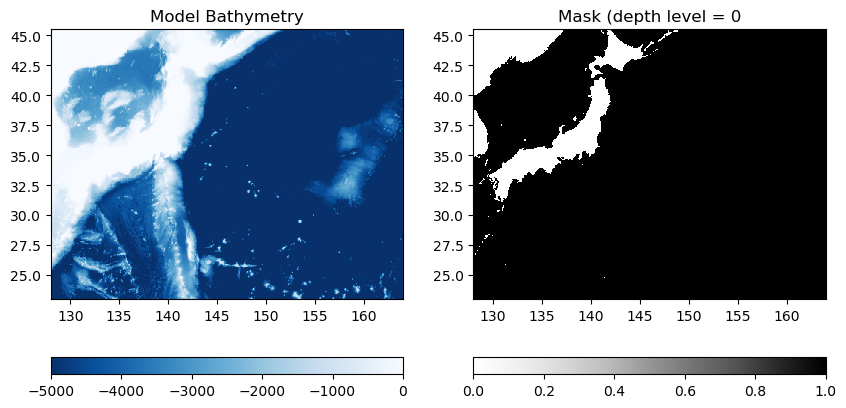

In [14]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
C = plt.pcolormesh(XC, YC, bathy, vmin=-5000, vmax=0, cmap='Blues_r')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Model Bathymetry')

depth_level = 0
plt.subplot(1,2,2)
C = plt.pcolormesh(XC, YC, mask[0], vmin=0, vmax=1, cmap='Greys')
plt.colorbar(C, orientation = 'horizontal')
plt.title('Mask (depth level = '+str(depth_level))

plt.show()

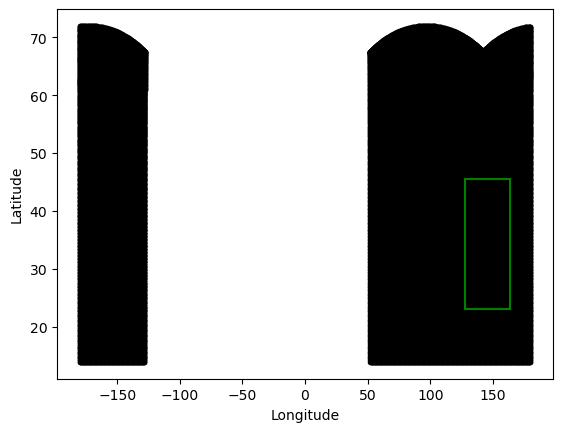

In [15]:
# plot the ECCO tile points from tiles 6 and 8

plt.plot(ecco_XC_tiles[6],ecco_YC_tiles[6],'k.')
plt.plot(ecco_XC_tiles[8],ecco_YC_tiles[8],'k.')

# plot the boundary of the CA model
plt.plot(XC[:,0],YC[:,0], 'g-')
plt.plot(XC[:,-1],YC[:,-1], 'g-')
plt.plot(XC[0,:],YC[0,:], 'g-')
plt.plot(XC[-1,:],YC[-1,:], 'g-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [16]:
tile_list = [6, 8]

# determine the number of points in each set
total_points = 0
for tile_number in tile_list:
    total_points += np.size(ecco_XC_tiles[tile_number])

# make empty arrays to fill in
ecco_XC_points = np.zeros((total_points, ))
ecco_YC_points = np.zeros((total_points, ))
ecco_hFacC_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacW_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_hFacS_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))
ecco_mask_points = np.zeros((np.size(ecco_RF_tiles[1]) , total_points))

# loop through the tiles and fill in the XC, YC, and mask points for interpolation
points_counted = 0
for tile_number in tile_list:
    tile_N = np.size(ecco_XC_tiles[tile_number])
    
    ecco_XC_points[points_counted:points_counted+tile_N] = ecco_XC_tiles[tile_number].ravel()
    ecco_YC_points[points_counted:points_counted+tile_N] = ecco_YC_tiles[tile_number].ravel()
    
    for k in range(np.size(ecco_RF_tiles[tile_number])):
        level_hFacC = ecco_hFacC_tiles[tile_number][k, :, :]
        level_hFacW = ecco_hFacW_tiles[tile_number][k, :, :]
        level_hFacS = ecco_hFacS_tiles[tile_number][k, :, :]
        level_mask = np.copy(level_hFacC)
        level_mask[level_mask>0] = 1
        ecco_hFacC_points[k, points_counted:points_counted+tile_N] = level_hFacC.ravel()
        ecco_hFacW_points[k, points_counted:points_counted+tile_N] = level_hFacW.ravel()
        ecco_hFacS_points[k, points_counted:points_counted+tile_N] = level_hFacS.ravel()
        ecco_mask_points[k,points_counted:points_counted+tile_N] = level_mask.ravel()
    
    points_counted += tile_N

print(ecco_YC_points)
print("Done reading in points from tile list")

[13.88656521 13.88656521 13.88656521 ... 14.48182297 14.18440723
 13.88656521]
Done reading in points from tile list


**Modifications to the initial conditions**

I'm using a Gaussian equation to raise the sea surface level at the specified latitude and longitude specified by mu_lat and mu_lon

Simulating two tsunamis. One at lat 30, lon 150 and one at lat 40, lon 135.

So tsunami one is in the Sea of Japan and tsunami two is in the North Pacific Sea.

The maximum increase of tsunami 1 & 2 is 0.009. I don't understand how sea elevation data works but the interpolated grid show it from a range of 0 - 1.0 so I figured raising sea elevation by 1% to simulate a tsunami should be fine.

Max increase of tsunami 1:  0.009547037780543256
Max increase of tsunami 2:  0.009547037780532402


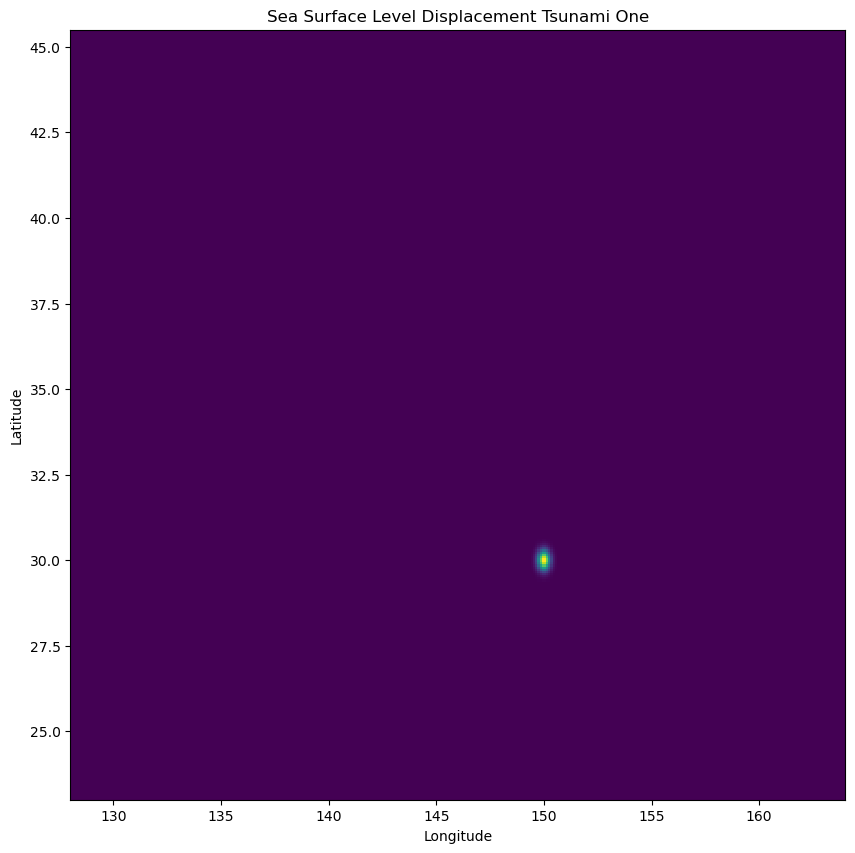

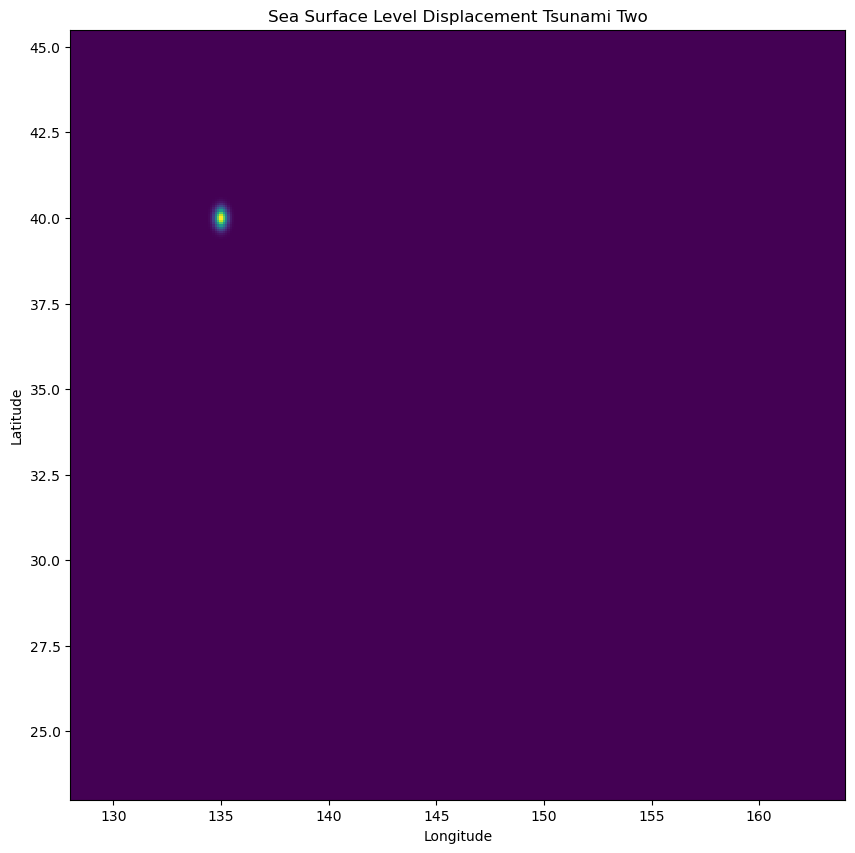

In [19]:

sigma = 0.5
mu_lat = 30
mu_lon = 150

tsunami_1 = 0.01 * np.exp(-((XC-mu_lon)**2 + (YC-mu_lat)**2)/(0.3*sigma**2))

mu_lat = 40
mu_lon = 135
tsunami_2 = 0.01 * np.exp(-((XC-mu_lon)**2 + (YC-mu_lat)**2)/(0.3*sigma**2))

print("Max increase of tsunami 1: ", np.max(tsunami_1))
print("Max increase of tsunami 2: ", np.max(tsunami_2))

plt.figure(figsize=(10,10))
plt.pcolormesh(XC, YC, tsunami_1, cmap='viridis')
plt.title("Sea Surface Level Displacement Tsunami One")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

plt.figure(figsize=(10,10))
plt.pcolormesh(XC, YC, tsunami_2, cmap='viridis')
plt.title("Sea Surface Level Displacement Tsunami Two")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [45]:
# make a file dictionary to loop over

# once tested with the above dict, run and comment with this one
file_prefix_dict = {'ETAN':'ETAN_2015.nc',
                    'THETA':'THETA_2015.nc',
                    'SALT':'SALT_2015.nc',
                    'UVEL':'UVELMASS_2015.nc',
                    'VVEL':'VVELMASS_2015.nc'}

variable_names = list(file_prefix_dict.keys())

In [46]:
# make a list to hold all of the ECCO grids
init_grids = []

# loop through each variable to read in the grid
for variable_name in variable_names:
    
    if variable_name == 'ETAN':
        ds = nc4.Dataset(os.path.join(data_folder,file_prefix_dict[variable_name]))
        grid = ds.variables[variable_name][:,:,:,:]
        ds.close()
    elif 'VEL' in variable_name:
        ds = nc4.Dataset(os.path.join(data_folder,'UVELMASS_2015.nc'))
        u_grid = ds.variables['UVELMASS'][:,:,:,:,:]
        ds.close()
        ds = nc4.Dataset(os.path.join(data_folder,'VVELMASS_2015.nc'))
        v_grid = ds.variables['VVELMASS'][:,:,:,:,:]
        ds.close()
    else:
        ds = nc4.Dataset(os.path.join(data_folder,file_prefix_dict[variable_name]))
        grid = ds.variables[variable_name][:,:,:,:,:]
        ds.close()
    
    # create a grid of zeros to fill in
    N = np.shape(grid)[-1]*np.shape(grid)[-2]
    if variable_name == 'ETAN':
        init_grid = np.zeros((1, N*len(tile_list)))
    else:
        init_grid = np.zeros((np.size(ecco_RF_tiles[1]), N*len(tile_list)))

    # loop through the tiles
    points_counted = 0
    for tile_number in tile_list:
        if variable_name == 'ETAN':
            init_grid[0,points_counted:points_counted+N] = \
                 grid[0, tile_number-1, :, :].ravel()
        elif 'VEL' in variable_name: # when using velocity, need to consider the tile rotations
            if variable_name == 'UVEL':
                if tile_number<7:
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[k,points_counted:points_counted+N] = \
                             u_grid[0, k, tile_number-1, :, :].ravel()
                else:
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[k,points_counted:points_counted+N] = \
                             v_grid[0, k, tile_number-1, :, :].ravel()
            if variable_name == 'VVEL':
                if tile_number<7:
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[k,points_counted:points_counted+N] = \
                             v_grid[0, k, tile_number-1, :, :].ravel()
                else:
                    for k in range(np.size(ecco_RF_tiles[1])):
                        init_grid[k,points_counted:points_counted+N] = \
                             -1*u_grid[0, k, tile_number-1, :, :].ravel()
        else:
            for k in range(np.size(ecco_RF_tiles[1])):
                init_grid[k,points_counted:points_counted+N] = \
                     grid[0, k, tile_number-1, :, :].ravel()
        points_counted += N

    # remove the points with positive longitudes
    #init_grid = init_grid[:,local_indices]

    # apply some corrections
    if variable_name == 'UVEL':
        for k in range(np.size(ecco_RF_tiles[1])):
            non_zero_indices = ecco_hFacW_points[k,:]!=0
            init_grid[k,non_zero_indices] = init_grid[k,non_zero_indices]/(ecco_hFacW_points[k,non_zero_indices])
    if variable_name == 'VVEL':
        for k in range(np.size(ecco_RF_tiles[1])):
            non_zero_indices = ecco_hFacS_points[k,:]!=0
            init_grid[k,non_zero_indices] = init_grid[k,non_zero_indices]/(ecco_hFacS_points[k,non_zero_indices])
    
    init_grids.append(init_grid)

In [47]:
from eccoseas.downscale import horizontal

Saving the initial conditions

For ETAN, also save the two initial conditions I created with the tsunamis

In [52]:
# loop through each variable and corresponding ECCO grid
for variable_name, init_grid in zip(variable_names, init_grids):

    # print a message to keep track of which variable we are working on
    # uncomment to use
    # print('    - Interpolating the '+variable_name+' grid')
    if variable_name == 'ETAN':
        model_mask = mask[:1,:,:]
    else:
        model_mask = mask

    interpolated_grid = horizontal.downscale_3D_points(np.column_stack([ecco_XC_points, ecco_YC_points]),
                                                       init_grid, ecco_mask_points, 
                                                       XC, YC, model_mask)

    
    if variable_name == 'ETAN':
        grid_with_tsunami_1 = np.copy(interpolated_grid) + tsunami_1
        grid_with_tsunami_2 = np.copy(interpolated_grid) + tsunami_2

    
    # output the interpolated grid
    # For ETAN, this will output the original ETAN without modifications
    # as well as two more files for the 2 tsunamis
    output_file = os.path.join(input_dir ,variable_name+'_IC.bin')
    interpolated_grid.ravel('C').astype('>f4').tofile(output_file)
    
    if variable_name == 'ETAN':
        path_1 = os.path.join(input_dir, 'ETAN_tsunami_1_IC.bin')
        path_2 = os.path.join(input_dir, 'ETAN_tsunami_2_IC.bin')
        grid_with_tsunami_1.ravel('C').astype('>f4').tofile(path_1)
        grid_with_tsunami_2.ravel('C').astype('>f4').tofile(path_2)
    

## Plotting the sea surface level modifications

After plotting the grid with tsunami one, can't really see any significant difference in the sea level but that's because I intentionally raised the sea level by a very small amount. 

The second plot show a difference in sea surface level between the grid with 1st tsunami and grid with 2nd tsunami which confirms that the adjustment I made to the sea surface level was 

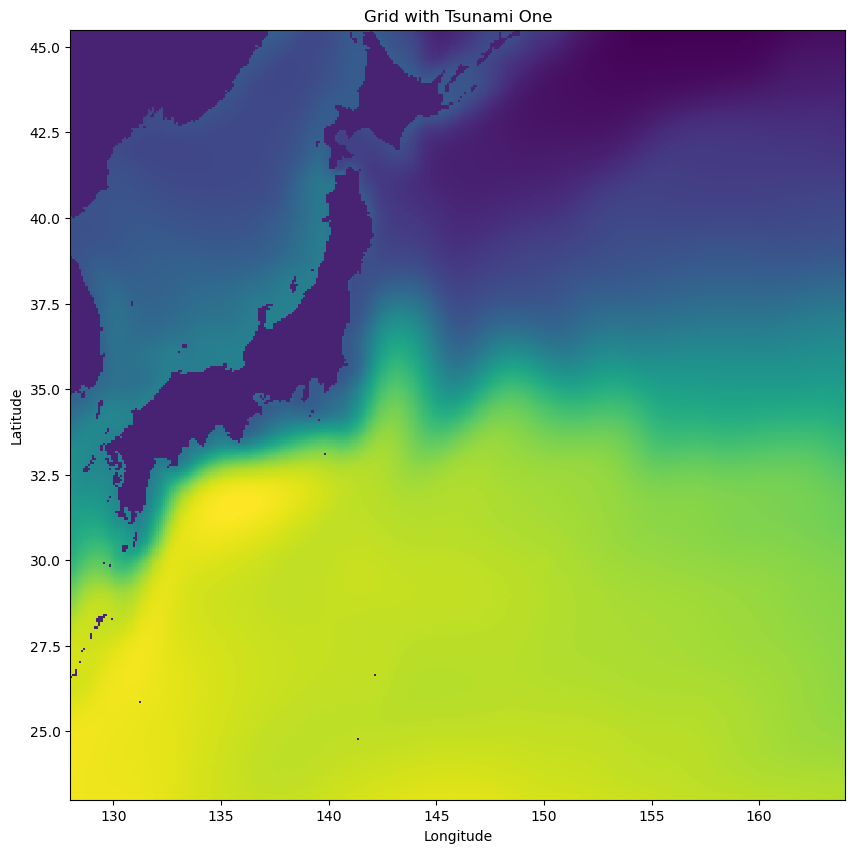

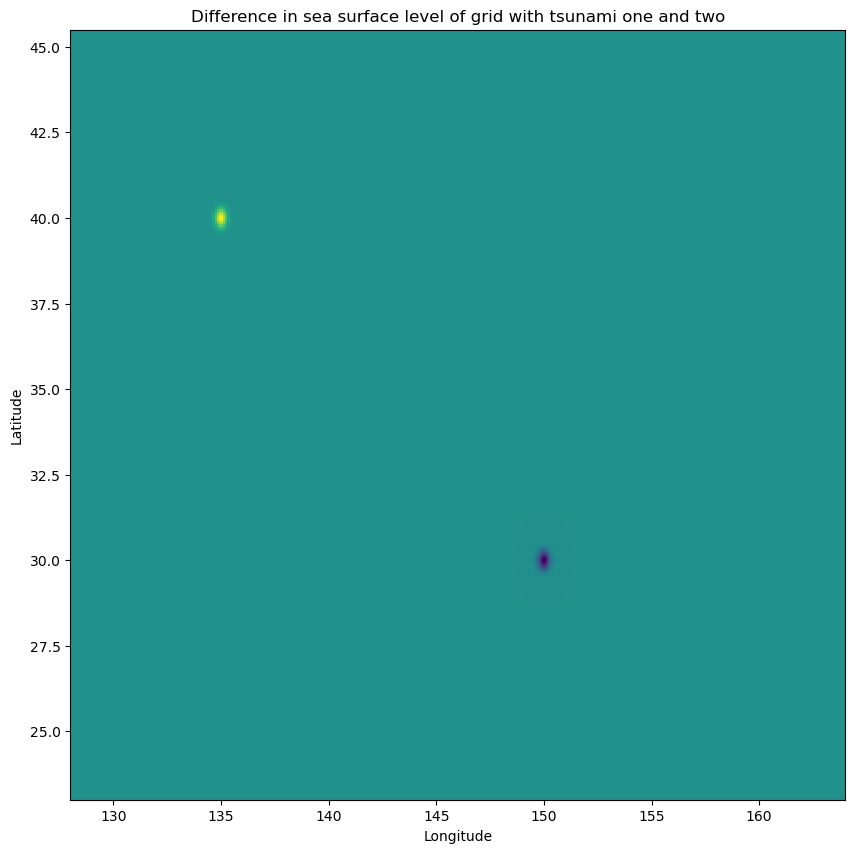

In [59]:

    
    plt.figure(figsize=(10,10))
    plt.pcolormesh(XC, YC, grid_with_tsunami_1[0,:,:], cmap='viridis')
    plt.title("Grid with Tsunami One")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
    plt.figure(figsize=(10,10))
    plt.pcolormesh(XC, YC, grid_with_tsunami_2[0,:,:] - grid_with_tsunami_1[0,:,:], cmap='viridis')
    plt.title("Difference in sea surface level of grid with tsunami one and two")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
    
    